<a href="https://colab.research.google.com/github/Sreelakshmi2023/MAINPROJECT-GROUP12/blob/main/cnn%2Btcn%2Blstm4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [31]:
!pip install keras-tcn

In [32]:
from tcn import TCN

In [33]:
from google.colab import files

# Use the 'files.upload()' method to upload files
uploaded = files.upload()

# Access the uploaded file
for filename, content in uploaded.items():
    with open(filename, 'wb') as f:
        f.write(content)

Saving phishing.csv to phishing (1).csv


In [34]:
import pandas as pd
# Replace 'your_dataset.csv' with the
df = pd.read_csv('phishing.csv')

In [35]:
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [36]:
df["type"].value_counts()

df["url_type"] = df["type"].replace({
    'benign':0,
    'defacement':1,
    'phishing':2,
    'malware':3
})

df.head()

,url,type,url_type
0,br-icloud.com.br,phishing,2
1,mp3raid.com/music/krizz_kaliko.html,benign,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1


In [38]:
# Assuming your CSV has columns 'url' and 'type'
urls = df['url'].tolist()
labels = df['url_type'].tolist()

In [39]:
# Convert labels to numerical format
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

In [40]:
# Tokenization and padding
max_sequence_length = 100  # You can adjust this based on your data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(urls)
sequences = tokenizer.texts_to_sequences(urls)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)


In [41]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, encoded_labels, test_size=0.2, random_state=42)


In [44]:
# Import the necessary module
max_sequence_length = 64
from tensorflow.keras.layers import Reshape

model = Sequential()

# Embedding layer
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50, input_length=max_sequence_length))

# CNN layer
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(2))

# TCN layer
model.add(TCN(nb_filters=64, kernel_size=3, dilations=[1, 2, 4, 8, 16]))

# Reshape the input data
model.add(Reshape((max_sequence_length, 1)))

# LSTM layer
model.add(LSTM(64))

# Dense layers
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))  # Multi-class classification



In [45]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


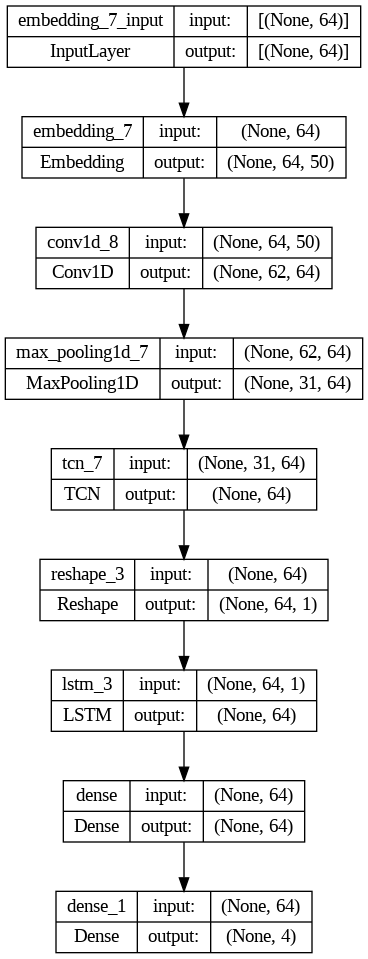

In [46]:
# Plot model architecture
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_architecture.png', show_shapes=True)


In [49]:
# Modify the input layer to accept the correct input shape
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50, input_length=100))

# Add the remaining layers of the model
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(TCN(nb_filters=64, kernel_size=3, dilations=[1, 2, 4, 8, 16]))
model.add(Reshape((64, 1)))
model.add(LSTM(64))
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))

# Compile and train the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/5
1683/1683 [==============================] - 268s 155ms/step - loss: 0.2222 - accuracy: 0.9265 - val_loss: 0.1336 - val_accuracy: 0.9480
Epoch 2/5
1683/1683 [==============================] - 249s 148ms/step - loss: 0.0618 - accuracy: 0.9803 - val_loss: 0.1244 - val_accuracy: 0.9469
Epoch 3/5
1683/1683 [==============================] - 257s 153ms/step - loss: 0.0241 - accuracy: 0.9928 - val_loss: 0.1654 - val_accuracy: 0.9295
Epoch 4/5
1683/1683 [==============================] - 248s 148ms/step - loss: 0.0147 - accuracy: 0.9959 - val_loss: 0.2133 - val_accuracy: 0.9345
Epoch 5/5
1683/1683 [==============================] - 255s 152ms/step - loss: 0.0090 - accuracy: 0.9978 - val_loss: 0.2060 - val_accuracy: 0.9406


In [50]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
rounded_accuracy = round(accuracy, 4)
print("Test Accuracy:", rounded_accuracy*100)


421/421 [==============================] - 13s 31ms/step - loss: 0.2060 - accuracy: 0.9406
Test Accuracy: 94.06


In [51]:
# Evaluate the model
y_pred = np.argmax(model.predict(X_test), axis=-1)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

421/421 [==============================] - 14s 27ms/step


In [53]:
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")

Accuracy: 0.9406
Precision: 0.9605
Recall: 0.9406
F1 Score: 0.9441
Confusion Matrix:
[[9521    1   18  299]
 [   0 2436   22    0]
 [ 210   10  420  213]
 [  13    0   14  281]]


In [54]:
def predict_maliciousness(url):
    sequence = tokenizer.texts_to_sequences([url])
    padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length)
    prediction = model.predict(padded_sequence)
    class_index = np.argmax(prediction[0])
    classes = ['benign', 'defacement', 'phishing', 'malware']
    return classes[class_index]


In [67]:
# Example usage:
user_url = "www.vedantu.com"
prediction = predict_maliciousness(user_url)
print(f"The URL {user_url} is predicted as: {prediction}")

1/1 [==============================] - 0s 36ms/step
The URL www.vedantu.com is predicted as: benign


421/421 [==============================] - 18s 41ms/step
Accuracy: 0.9406
Precision: 0.9605
Recall: 0.9406
F1 Score: 0.9441
ROC AUC: 0.9898


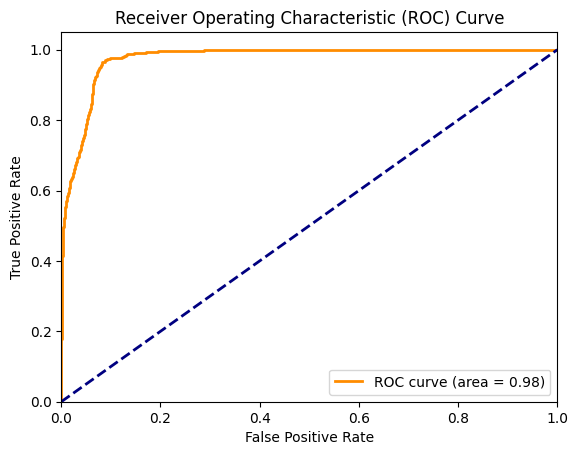

In [68]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Evaluate the model on the test set
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred_labels)
precision = precision_score(y_test, y_pred_labels, average='weighted')
recall = recall_score(y_test, y_pred_labels, average='weighted')
f1 = f1_score(y_test, y_pred_labels, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred, average='macro', multi_class='ovr')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')

# Plot ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred[:, i], pos_label=i)
    roc_auc[i] = roc_auc_score((y_test == i).astype(int), y_pred[:, i])

plt.figure()
plt.plot(fpr[2], tpr[2], color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()